# Clasificación No Balanceada en Inversiones Startups (Crunchbase)

Este trabajo aborda un problema de **clasificación binaria no balanceada** a partir de un dataset abierto de inversiones en startups, disponible en [Kaggle - Startup Investments Crunchbase](https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase/data).

## Descripción del Proyecto

Este proyecto se desarrolla para la asignatura de **Minería de Datos**, como parte del trabajo final grupal. El objetivo es aplicar técnicas de análisis y modelado sobre un conjunto de datos reales para abordar un problema de clasificación desequilibrada.

A partir del dataset original, se ha redefinido el problema como una clasificación binaria no balanceada. Por ejemplo, se puede predecir si una startup ha recibido financiación por encima de un determinado umbral, o si pertenece a un grupo de industrias consideradas “de alto crecimiento”.

## Objetivos

1. **Formulación del problema** como tarea de clasificación binaria no balanceada.
2. **Análisis exploratorio** de las variables del dataset.
3. **Preparación de los datos**, incluyendo tratamiento de valores perdidos, normalización, codificación y detección de outliers.
4. Aplicación de **técnicas de aprendizaje supervisado**:
   - **K-Nearest Neighbors (KNN)**
   - **Árboles de Decisión**
5. Evaluación mediante **métricas adecuadas** para clasificación no balanceada (como *F1-Score*, *balanced accuracy*, *AUC*, etc.) y **validación cruzada**.
6. Uso de **pipelines y transformadores** para automatizar el preprocesamiento.
7. Aplicación de técnicas de **muestreo (undersampling/oversampling)** y **ajuste de umbrales**.
8. Estudio de la **interpretabilidad del modelo final**.

## Estructura del Notebook

Este notebook está estructurado en las siguientes secciones:

- [1. Carga y descripción del dataset](#)
- [2. Análisis exploratorio de los datos (EDA)](#)
- [3. Formulación del problema de clasificación binaria no balanceada](#)
- [4. Preprocesamiento de datos](#)
- [5. Construcción del pipeline con KNN](#)
- [6. Evaluación del modelo y análisis de resultados](#)
- [7. Árboles de decisión y comparación](#)
- [8. Interpretabilidad del modelo final](#)
- [9. Conclusiones](#)

## 1. Elección del problema

El problema elegido se basa en el dataset **Startup Investments - Crunchbase**, disponible en [Kaggle](https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase/data).

El objetivo es construir un modelo de **clasificación binaria no balanceada** que permita **predecir si una startup será adquirida** o no. Para ello, hemos definido la variable objetivo `target` de la siguiente forma:

- `target = 1` si la columna `status` es `"acquired"`
- `target = 0` en cualquier otro caso (por ejemplo: `closed`, `ipo`, `operating`, etc.)

Este planteamiento genera un claro desbalance entre clases, ya que el número de startups adquiridas es mucho menor que el resto.

Comenzamos leyendo el dataset original sobre inversiones en startups, proporcionado por Crunchbase y disponible en [Kaggle](https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase/data).

El objetivo en esta fase inicial es familiarizarnos con la estructura de los datos: número de ejemplos, variables disponibles, tipos de datos y primeras observaciones. Esto nos permitirá definir correctamente el problema de clasificación binaria no balanceada.

El archivo utilizado se llama `investments_VC.csv` y se encuentra en la carpeta `data/`.

In [1]:
import pandas as pd

ruta_datos = "data/investments_VC.csv"

df = pd.read_csv(ruta_datos, encoding="latin1")
df.columns = df.columns.str.strip()

print("Dimensiones del dataset: ", df.shape)
df.head()

Dimensiones del dataset:  (54294, 39)


,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,NaN,Tallinn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Métrica de rendimiento y validación

Dado que se trata de un problema de **clasificación no balanceada**, y el enfoque del proyecto es el de una entidad inversora interesada en identificar startups que realmente serán adquiridas, el objetivo por tanto, será optimizar el número de **falsos positivos**, es decir, evitar etiquetar como "adquirida" una startup que realmente no lo será, lo cual es crucial desde una perspectiva de inversión.

Para ello, utilizaremos como métricas principales **Fβ-score** y **AUC - Precision Recall**. Como nos interesa minimizar el número de falsos positivos, tenemos que dar más peso a la precisión. Por ello, al valor de beta le asignamos un valor <1, le daremos un valor 0.7.

- **Fβ-score**: como nos explicó en clase de prácticas, permite ajustar la importancia del *recall* frente a la *precisión*, según lo que queramos priorizar.
- **AUC - Precision Recall**: evalúa qué tan bien se separan las clases, especialmente en problemas desbalanceados.



### Validación

Usaremos Hold-out estratificado porque así nos aseguramos de que cada partición de nuestro conjunto de datos mantenga la misma proporción de clases que el conjunto original. Esto es muy importante en nuestro caso, ya que tenemos un problema de clasificación en el que las clases están desbalanceadas. Al asegurarnos de que cada fold represente la distribución de clases, evitamos sesgos en la evaluación del rendimiento y obtenemos mejores estimaciones. Además, nos ayuda a usar mejor nuestros datos y a entrenar modelos que aprendan de forma más equilibrada y realista según cómo es de verdad el problema.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, precision_recall_curve, auc

def evaluar_pipeline(X, y, pipeline, beta=0.7, test_size=0.2, random_state=1):
    # Holdout Estratificado
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    
    # Entrenamiento del modelo
    pipeline.fit(X_train, y_train)
    
    # Predicciones
    y_pred = pipeline.predict(X_test)
    
    # Probabilidades de predicción (para AUC - Precision Recall)
    if hasattr(pipeline, "predict_proba"):
        y_proba = pipeline.predict_proba(X_test)[:, 1]  # Solo clase positiva
    elif hasattr(pipeline, "decision_function"):
        y_proba = pipeline.decision_function(X_test)
    else:
        y_proba = None

    # Cálculo de las métricas
    puntuaciones = {
        "f_beta": fbeta_score(y_test, y_pred, beta=beta),  # Fβ-score con β=0.7
    }
    
    # AUC - Precision-Recall
    if y_proba is not None:
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        auc_pr = auc(recall, precision)  # Cálculo de AUC-PR
        puntuaciones["AUC-PR"] = auc_pr
    else:
        puntuaciones["AUC-PR"] = 0  # Si no se pueden calcular las probabilidades

    return puntuaciones

## 3. Análisis de las variables de entrada

El dataset contiene información sobre startups, incluyendo el país, la categoría, la cantidad de inversión recibida, el número de rondas de financiación, y fechas clave como fundación y adquisiciones.

Variables candidatas para el modelo:

- `country_code`
- `category_code`
- `funding_total_usd`
- `funding_rounds`
- `founded_at`
- `first_funding_at`
- `last_funding_at`

Se han detectado:
- Variables numéricas con escalas muy diferentes
- Fechas con valores ausentes o mal formateados
- Variables categóricas con muchos valores únicos
- Campos de texto que se ignorarán o transformarán

El análisis preliminar sugiere que las startups con más financiación y más rondas de inversión tienen mayor probabilidad de ser adquiridas.


Lo primero que hacemos es renombrar la variable a predecir. Se llama `status` y le llamamos `exito`.

In [3]:
df.rename(columns = {'status':'exito'}, inplace = True)
pd.set_option('display.max_columns', None)
df.head()
#borrar variables: 
# permalink, name, state_code


,permalink,name,homepage_url,category_list,market,funding_total_usd,exito,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,New York,1.0,2012-06-01,2012-06,2012-Q2,2012.0,2012-06-30,2012-06-30,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,Los Angeles,2.0,NaN,NaN,NaN,NaN,2010-06-04,2010-09-23,0.0,4000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,NaN,Tallinn,Tallinn,1.0,2012-10-26,2012-10,2012-Q4,2012.0,2012-08-09,2012-08-09,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,London,1.0,2011-04-01,2011-04,2011-Q2,2011.0,2011-04-01,2011-04-01,1500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas,Fort Worth,2.0,2014-01-01,2014-01,2014-Q1,2014.0,2014-08-17,2014-09-26,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora visualizamos la descripción de nuestro dataset con `describe` de la libría `pandas`

In [4]:
df.describe()

,funding_rounds,founded_year,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
count,49438.000000,38482.000000,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04
mean,1.696205,2007.359129,2.173215e+05,7.501051e+06,6.163322e+03,1.302213e+05,2.336410e+04,1.888157e+06,6.541898e+04,1.628453e+05,2.074286e+06,6.088736e+05,4.434360e+05,3.845592e+04,7.074227e+03,1.243955e+06,1.492891e+06,1.205356e+06,7.375261e+05,3.424682e+05,1.697692e+05,5.767067e+04,1.423197e+04
std,1.294213,7.579203,1.056985e+06,2.847112e+07,1.999048e+05,2.981404e+06,1.432046e+06,1.382046e+08,6.582908e+05,5.612088e+06,3.167231e+07,2.678348e+07,3.428169e+07,3.864461e+06,4.282166e+05,5.531974e+06,7.472704e+06,7.993592e+06,9.815218e+06,5.406915e+06,6.277905e+06,5.252312e+06,2.716865e+06
min,1.000000,1902.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,2006.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000,2010.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000,2012.000000,2.500000e+04,5.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,18.000000,2014.000000,1.300000e+08,2.351000e+09,2.500000e+07,2.924328e+08,3.000000e+08,3.007950e+10,6.359026e+07,7.505000e+08,3.500000e+09,4.700000e+09,5.800000e+09,6.806116e+08,7.200000e+07,3.190000e+08,5.420000e+08,4.900000e+08,1.200000e+09,4.000000e+08,1.060000e+09,1.000000e+09,6.000000e+08


Eliminamos valores nulos de la variable de salida

In [5]:
#poner arriba
#Observamos cuantos valores NaN hay en cada columna, además de ver que columnas son de tipo object y cuales son numéricas
print(df.isnull().sum())
#hay 4856 valores nulos en muchas columnas, peor hay 6170 valores nulos en exito, que hay que eliminar si o si
print(df.dtypes)
#eliminamos filas en las que exito es nulo, si no tenemos salida no interesa
df = df.dropna(subset=['exito'])
print(df.isnull().sum())

permalink                4856
name                     4857
homepage_url             8305
category_list            8817
market                   8824
funding_total_usd        4856
exito                    6170
country_code            10129
state_code              24133
region                  10129
city                    10972
funding_rounds           4856
founded_at              15740
founded_month           15812
founded_quarter         15812
founded_year            15812
first_funding_at         4856
last_funding_at          4856
seed                     4856
venture                  4856
equity_crowdfunding      4856
undisclosed              4856
convertible_note         4856
debt_financing           4856
angel                    4856
grant                    4856
private_equity           4856
post_ipo_equity          4856
post_ipo_debt            4856
secondary_market         4856
product_crowdfunding     4856
round_A                  4856
round_B                  4856
round_C   

Utilizamos describe otra vez para ver cambios tras eliminar filas sin etiqueta

In [6]:
pd.set_option('display.max_columns', None)
df.describe()

,funding_rounds,founded_year,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
count,48124.000000,37564.000000,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04
mean,1.700586,2007.388856,2.191042e+05,7.598091e+06,6.255879e+03,1.273428e+05,2.353346e+04,1.909246e+06,6.605675e+04,1.626366e+05,2.083347e+06,5.812357e+05,4.069734e+05,3.940828e+04,7.164047e+03,1.257983e+06,1.512301e+06,1.229792e+06,7.545214e+05,3.499801e+05,1.741948e+05,5.924533e+04,1.462056e+04
std,1.298296,7.523989,1.068580e+06,2.877746e+07,2.024335e+05,2.971224e+06,1.450830e+06,1.400643e+08,6.645587e+05,5.664512e+06,3.199324e+07,2.706492e+07,3.437831e+07,3.916802e+06,4.336993e+05,5.577529e+06,7.544910e+06,8.086419e+06,9.944356e+06,5.472720e+06,6.362813e+06,5.323528e+06,2.753707e+06
min,1.000000,1902.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,2006.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000,2010.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000,2012.000000,2.500000e+04,5.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,18.000000,2014.000000,1.300000e+08,2.351000e+09,2.500000e+07,2.924328e+08,3.000000e+08,3.007950e+10,6.359026e+07,7.505000e+08,3.500000e+09,4.700000e+09,5.800000e+09,6.806116e+08,7.200000e+07,3.190000e+08,5.420000e+08,4.900000e+08,1.200000e+09,4.000000e+08,1.060000e+09,1.000000e+09,6.000000e+08


Podemos observar que las empresas de nuestros datos se fundaron entre 1902 y 2014

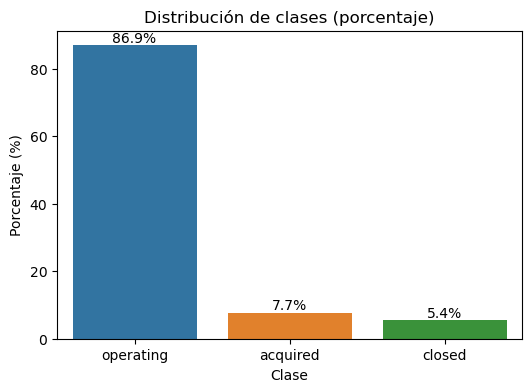

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
target = 'exito'


porcentajes = df[target].value_counts(normalize=True) * 100


plt.figure(figsize=(6,4))
ax = sns.barplot(x=porcentajes.index, y=porcentajes.values)
for i, v in enumerate(porcentajes.values):
    ax.text(i, v+1, f"{v:.1f}%", ha='center')
ax.set_title("Distribución de clases (porcentaje)")
ax.set_xlabel("Clase")
ax.set_ylabel("Porcentaje (%)")
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

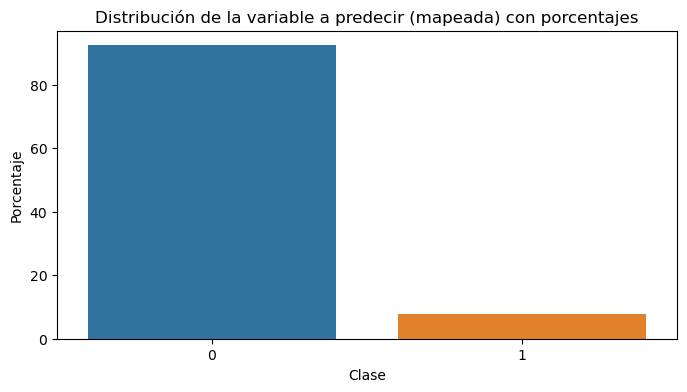

In [8]:
# target = 'exito'
# mapping = {'operating': 0, 'closed': 0, 'acquired': 1}
# df[target] = df[target].map(mapping)

# Calcular los porcentajes de cada clase en la variable 'exito'
# percentages = df[target].value_counts(normalize=True) * 100
mapping = {
    'acquired':  1,
    'closed':    0,
    'operating': 0,
    'ipo':       0
}
df['exito'] = df['exito'].map(mapping) \
                       .fillna(0) \
                       .astype(int)

# 2) Calcular porcentajes
percentages = df['exito'].value_counts(normalize=True) * 100 
# Crear el gráfico de barras con porcentajes
plt.figure(figsize=(8, 4))
sns.barplot(x=percentages.index, y=percentages.values)

# Configuración del gráfico
plt.title('Distribución de la variable a predecir (mapeada) con porcentajes')
plt.xlabel('Clase')
plt.ylabel('Porcentaje')
plt.show

In [9]:
def year_group(row):
    if row['founded_year'] >= 1900 and row['founded_year'] <= 1925:
        row['founded_year_group'] = 'less_than_1925'
    elif row['founded_year'] > 1925 and row['founded_year'] <= 1950:
        row['founded_year_group'] = '1925_1950'
    elif row['founded_year'] > 1950 and row['founded_year'] <= 1975:
        row['founded_year_group'] = '1950_1975'
    elif row['founded_year'] > 1975 and row['founded_year'] <= 2000:
        row['founded_year_group'] = '1975_2000'
    elif row['founded_year'] > 2000:
        row['founded_year_group'] = '2000_2014'
    else:
        row['founded_year_group'] = ''
    return row['founded_year_group']

df['founded_year_group'] =  df.apply(year_group,axis =1)

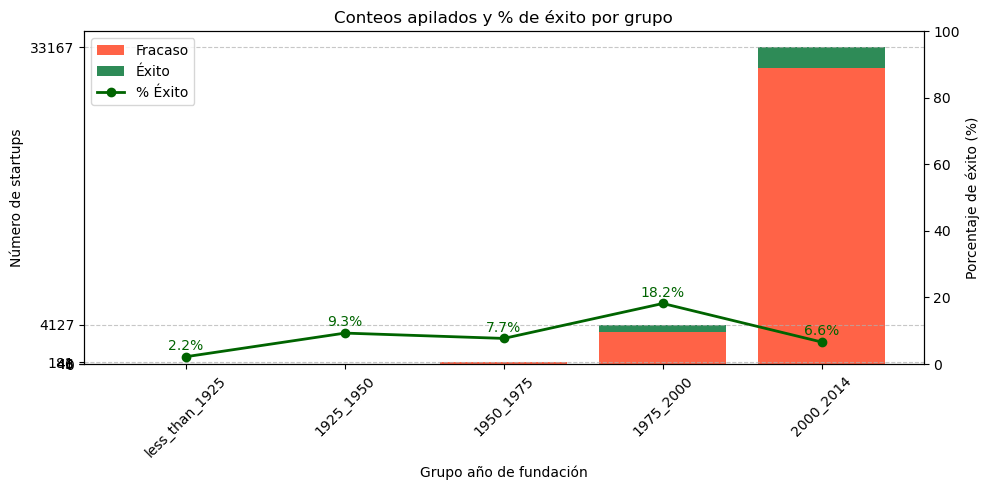

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1) Preparar los datos
grouped = df.groupby('founded_year_group')['exito'].value_counts().unstack(fill_value=0)

ordered_groups = [
    'less_than_1925',
    '1925_1950',
    '1950_1975',
    '1975_2000',
    '2000_2014'
]

fails  = grouped.loc[ordered_groups, 0]
succs  = grouped.loc[ordered_groups, 1]
totals = fails + succs
pct_succs = (succs / totals * 100).round(1)

# 2) Dibujar las barras apiladas
fig, ax1 = plt.subplots(figsize=(10,5))

bar1 = ax1.bar(ordered_groups, fails,  label='Fracaso', color='tomato')
bar2 = ax1.bar(ordered_groups, succs, bottom=fails, label='Éxito',   color='seagreen')

# 3) Fijar los ticks del eje Y a los totales (y al 0)
yticks = np.concatenate([[0], totals.values])
ax1.set_yticks(sorted(yticks))
ax1.set_ylabel("Número de startups")
ax1.set_xlabel("Grupo año de fundación")
ax1.set_title("Conteos apilados y % de éxito por grupo")
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 4) Eje secundario de porcentaje
ax2 = ax1.twinx()
ax2.plot(ordered_groups, pct_succs, color='darkgreen', marker='o', linewidth=2, label='% Éxito')
ax2.set_ylabel("Porcentaje de éxito (%)")
ax2.set_ylim(0, 100)

# 5) Anotar % de éxito encima de cada punto
for x, pct in zip(ordered_groups, pct_succs):
    ax2.text(x, pct + 2, f"{pct}%", ha='center', color='darkgreen')

# 6) Leyenda combinada
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.tight_layout()
plt.show()


Se puede observar que casi todas las empresas se fundan entre el año `2000` y `2014`. Por ello, ahora ploteamos la gráfica de solo los años `2000` a `2014`.

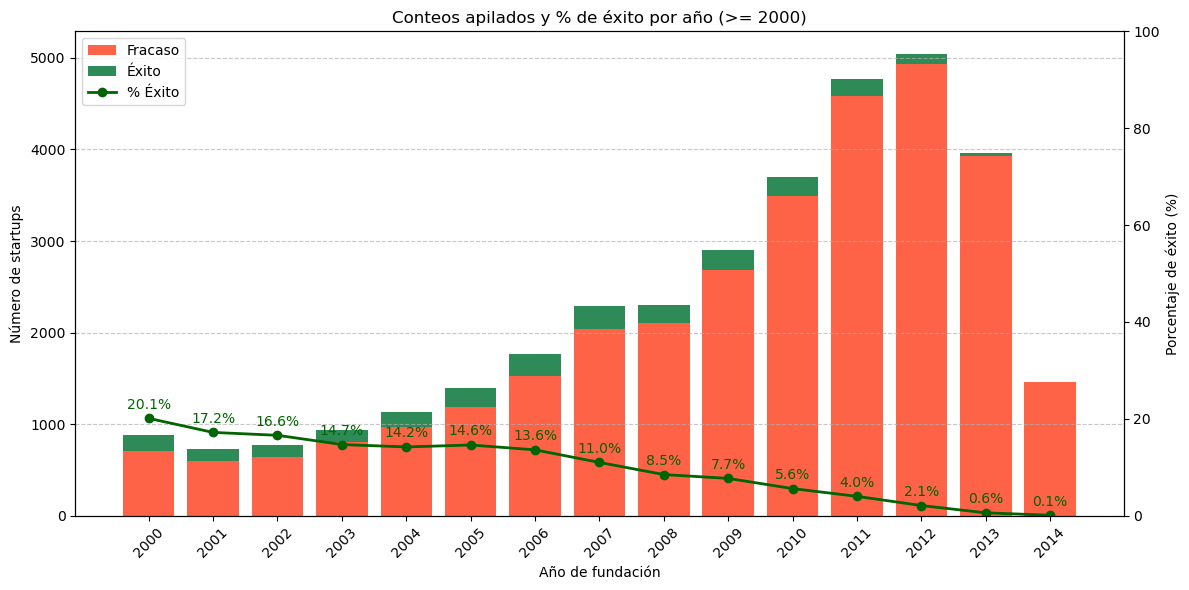

In [11]:
# 1) Filtrar los datos para años de fundación >= 2000
df_new = df[df['founded_year'] >= 2000].copy()
df_new['founded_year'] = df_new['founded_year'].astype(int)

# 2) Preparar los datos agrupados por año de fundación
grouped = df_new.groupby('founded_year')['exito'].value_counts().unstack(fill_value=0)

fails = grouped.get(0, pd.Series(dtype=int))
succs = grouped.get(1, pd.Series(dtype=int))
totals = fails + succs
pct_succs = (succs / totals * 100).round(1)
years = grouped.index.tolist()

# 3) Dibujar las barras apiladas
fig, ax1 = plt.subplots(figsize=(12, 6))

bar1 = ax1.bar(years, fails, label='Fracaso', color='tomato')
bar2 = ax1.bar(years, succs, bottom=fails, label='Éxito', color='seagreen')

# 4) Fijar las etiquetas del eje X a todos los años
ax1.set_xticks(years)
ax1.set_ylabel("Número de startups")
ax1.set_xlabel("Año de fundación")
ax1.set_title("Conteos apilados y % de éxito por año (>= 2000)")
ax1.tick_params(axis='x', rotation=45)

# El eje Y ahora usará los ticks predeterminados de Matplotlib
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 5) Eje secundario de porcentaje
ax2 = ax1.twinx()
ax2.plot(years, pct_succs, color='darkgreen', marker='o', linewidth=2, label='% Éxito')
ax2.set_ylabel("Porcentaje de éxito (%)")
ax2.set_ylim(0, 100)

# 6) Anotar % de éxito encima de cada punto
for x, pct in zip(years, pct_succs):
    ax2.text(x, pct + 2, f"{pct}%", ha='center', color='darkgreen')

# 7) Leyenda combinada
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.tight_layout()
plt.show()

Sin embargo, el intervalo de tiempo en el que las empresas tienen mayor éxito (en proporción) es entre `1975` y el año `2000`, por lo que mostramos también su gráfica.

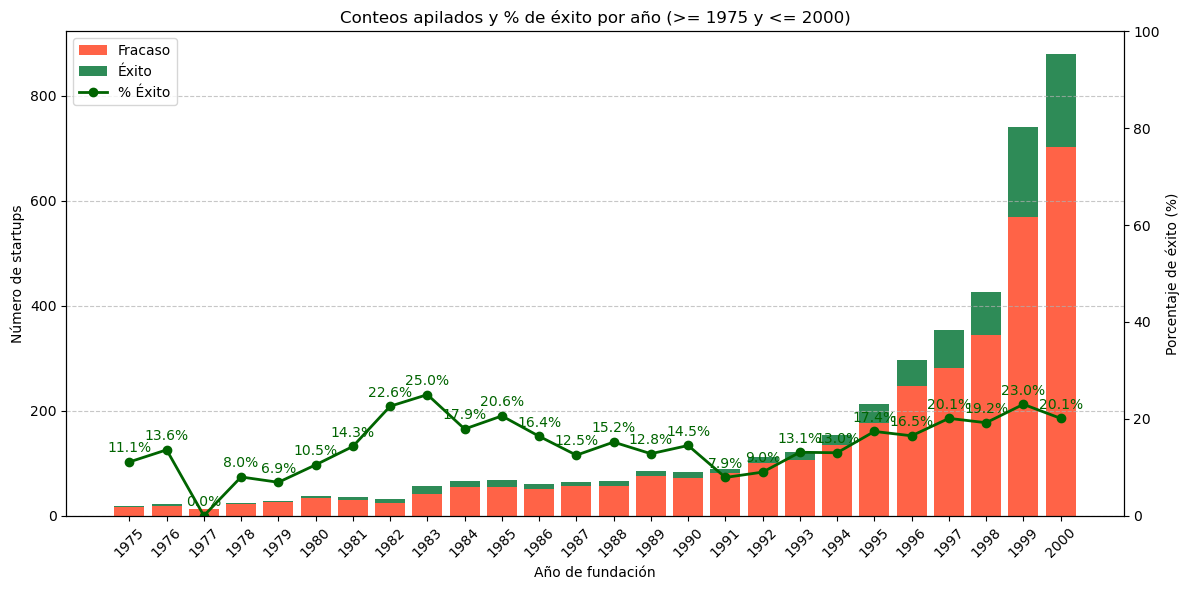

In [12]:
# 1) Filtrar los datos para años de fundación >= 2000
df_new = df[(df['founded_year'] >= 1975) & (df['founded_year'] <= 2000)].copy()
df_new['founded_year'] = df_new['founded_year'].astype(int)

# 2) Preparar los datos agrupados por año de fundación
grouped = df_new.groupby('founded_year')['exito'].value_counts().unstack(fill_value=0)

fails = grouped.get(0, pd.Series(dtype=int))
succs = grouped.get(1, pd.Series(dtype=int))
totals = fails + succs
pct_succs = (succs / totals * 100).round(1)
years = grouped.index.tolist()

# 3) Dibujar las barras apiladas
fig, ax1 = plt.subplots(figsize=(12, 6))

bar1 = ax1.bar(years, fails, label='Fracaso', color='tomato')
bar2 = ax1.bar(years, succs, bottom=fails, label='Éxito', color='seagreen')

# 4) Fijar las etiquetas del eje X a todos los años
ax1.set_xticks(years)
ax1.set_ylabel("Número de startups")
ax1.set_xlabel("Año de fundación")
ax1.set_title("Conteos apilados y % de éxito por año (>= 1975 y <= 2000)")
ax1.tick_params(axis='x', rotation=45)

# El eje Y ahora usará los ticks predeterminados de Matplotlib
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 5) Eje secundario de porcentaje
ax2 = ax1.twinx()
ax2.plot(years, pct_succs, color='darkgreen', marker='o', linewidth=2, label='% Éxito')
ax2.set_ylabel("Porcentaje de éxito (%)")
ax2.set_ylim(0, 100)

# 6) Anotar % de éxito encima de cada punto
for x, pct in zip(years, pct_succs):
    ax2.text(x, pct + 2, f"{pct}%", ha='center', color='darkgreen')

# 7) Leyenda combinada
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.tight_layout()
plt.show()

### Análisis de la intensidad de financiación

En este bloque de código vamos a explorar cómo el monto total de financiación recibido por cada startup se relaciona con su probabilidad de éxito:

1. **Limpieza y conversión**  
   - Eliminamos caracteres no numéricos (como comas) de la columna `funding_total_usd` y la convertimos a tipo numérico.  
   - Descartamos las filas donde no hay información de financiación.

2. **Discretización en intervalos**  
   - Definimos una serie de rangos (bins) que agrupan las startups según franjas de inversión (por ejemplo, `<100K`, `100K–1M`, etc.).

3. **Cálculo de éxitos y fracasos**  
   - Agrupamos el número de startups adquiridas (`exito = 1`) y no adquiridas (`exito = 0`) en cada intervalo.

4. **Visualización**  
   - Generamos un gráfico de barras **apiladas** para mostrar el conteo de éxitos y fracasos por intervalo.  
   - Sobre el mismo eje, trazamos una **línea** que indica el porcentaje de éxito dentro de cada rango de financiación.

Este análisis nos ayuda a identificar de manera intuitiva si existe algún umbral de inversión por encima del cual las startups muestran una mayor probabilidad de ser adquiridas.


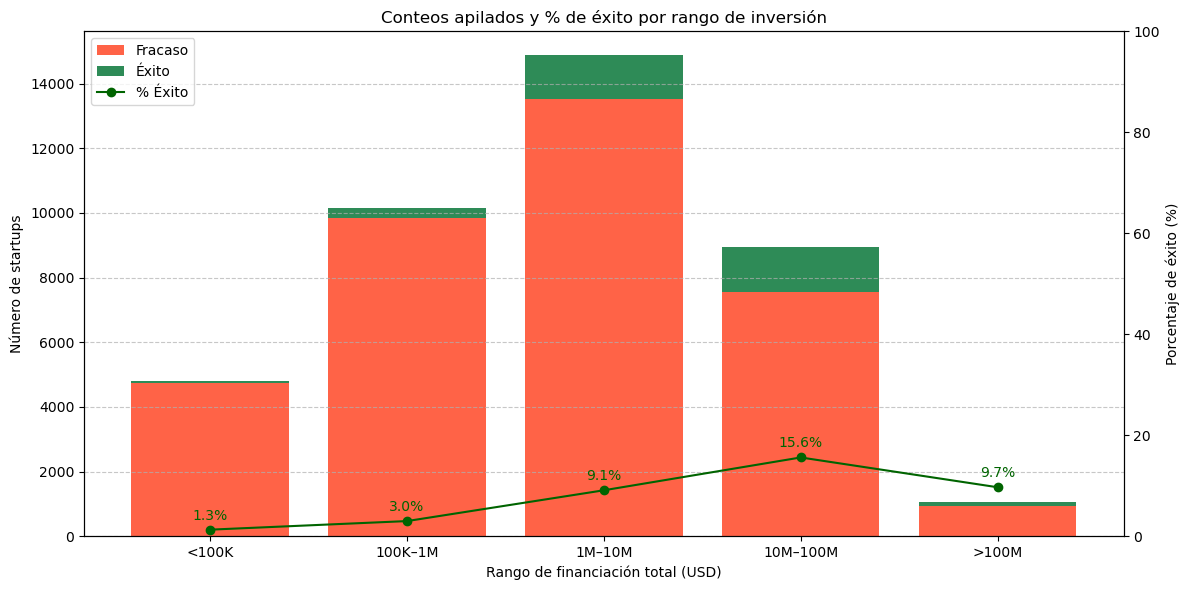

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) LIMPIEZA Y CONVERSIÓN de funding_total_usd
df['funding_total_usd'] = (
    df['funding_total_usd']
      .astype(str)
      .str.replace(',', '', regex=False)
)
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'], errors='coerce')
df = df.dropna(subset=['funding_total_usd']).copy()

# 2) DEFINIR BINS Y ETIQUETAS
bins = [0, 1e5, 1e6, 1e7, 1e8, df['funding_total_usd'].max()]
labels = ['<100K', '100K–1M', '1M–10M', '10M–100M', '>100M']
df['fnd_bin'] = pd.cut(
    df['funding_total_usd'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)

# 3) AGRUPAR ÉXITOS/FRACASOS (**sin volver a remapear exito**)
grouped = (
    df
    .groupby('fnd_bin')['exito']
    .value_counts()
    .unstack(fill_value=0)
    .reindex(labels, fill_value=0)
)

fails = grouped[0]
succs = grouped[1]
totals = fails + succs
pct    = (succs / totals * 100).round(1).fillna(0)

# 4) PLOT Apilado + Línea de %
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(labels, fails,  color='tomato',    label='Fracaso')
ax1.bar(labels, succs, bottom=fails, color='seagreen', label='Éxito')
ax1.set_xlabel("Rango de financiación total (USD)")
ax1.set_ylabel("Número de startups")
ax1.set_title("Conteos apilados y % de éxito por rango de inversión")
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2 = ax1.twinx()
ax2.plot(labels, pct, color='darkgreen', marker='o', label='% Éxito')
ax2.set_ylabel("Porcentaje de éxito (%)")
ax2.set_ylim(0, 100)

for x, p in zip(labels, pct):
    ax2.text(x, p + 2, f"{p:.1f}%", ha='center', color='darkgreen')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.tight_layout()
plt.show()

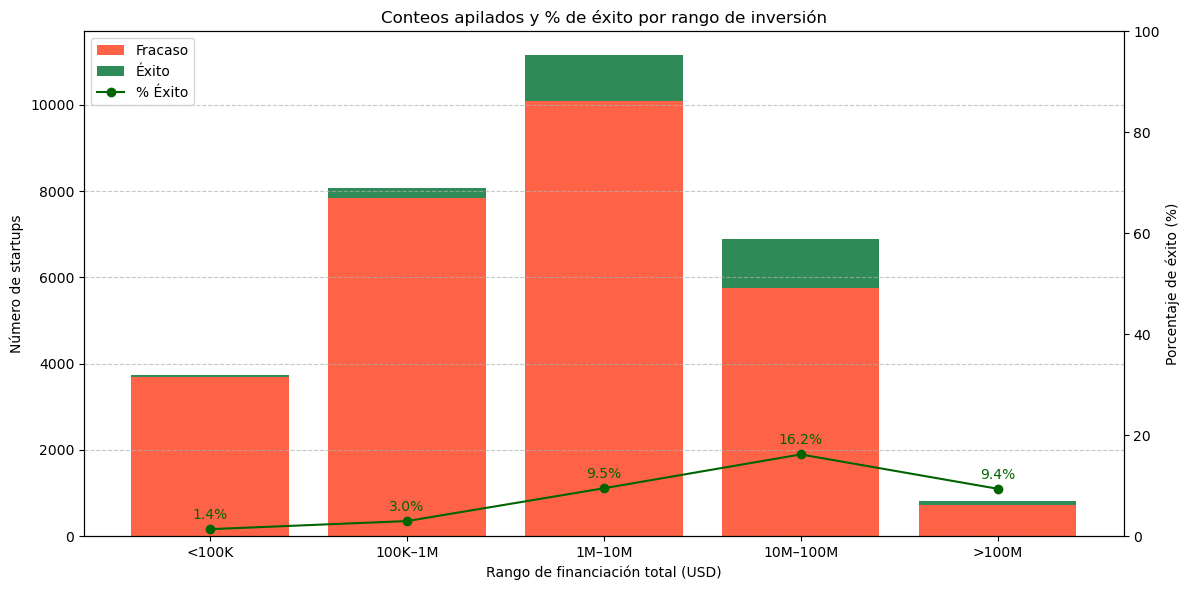

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtrar datos para incluir solo startups fundadas después de 1990
df = df[df['founded_year'] >= 1990].copy()

# 1) LIMPIEZA Y CONVERSIÓN de funding_total_usd
df['funding_total_usd'] = (
    df['funding_total_usd']
      .astype(str)
      .str.replace(',', '', regex=False)
)
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'], errors='coerce')
df = df.dropna(subset=['funding_total_usd']).copy()

# 2) DEFINIR BINS Y ETIQUETAS
bins = [0, 1e5, 1e6, 1e7, 1e8, df['funding_total_usd'].max()]
labels = ['<100K', '100K–1M', '1M–10M', '10M–100M', '>100M']

df['fnd_bin'] = pd.cut(
    df['funding_total_usd'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)

# 3) AGRUPAR ÉXITOS/FRACASOS y manejar valores ausentes
grouped = (
    df
    .groupby('fnd_bin')['exito']
    .value_counts()
    .unstack(fill_value=0)  # Asegura que los valores vacíos se rellenen con 0
)

# Reindexar para asegurarse de que todos los bins estén presentes, incluso si no hay datos para alguno
grouped = grouped.reindex(labels, fill_value=0)

# Ahora obtenemos las métricas
fails = grouped[0]  # Fracasos
succs = grouped[1]  # Éxitos
totals = fails + succs  # Total de startups por bin
pct = (succs / totals * 100).round(1).fillna(0)  # Porcentaje de éxito

# 4) PLOT Apilado + Línea de %
fig, ax1 = plt.subplots(figsize=(12, 6))

# Crear gráfico apilado
ax1.bar(labels, fails, color='tomato', label='Fracaso')
ax1.bar(labels, succs, bottom=fails, color='seagreen', label='Éxito')
ax1.set_xlabel("Rango de financiación total (USD)")
ax1.set_ylabel("Número de startups")
ax1.set_title("Conteos apilados y % de éxito por rango de inversión")
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Crear el eje para la línea de porcentaje
ax2 = ax1.twinx()
ax2.plot(labels, pct, color='darkgreen', marker='o', label='% Éxito')
ax2.set_ylabel("Porcentaje de éxito (%)")
ax2.set_ylim(0, 100)

# Añadir etiquetas de porcentaje sobre la línea
for x, p in zip(labels, pct):
    ax2.text(x, p + 2, f"{p:.1f}%", ha='center', color='darkgreen')

# Unir las leyendas de ambos gráficos
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()
plt.show()


### Impacto del número de rondas de financiación

Este gráfico muestra cómo el número de rondas de financiación influye en la probabilidad de adquisición:

1. **Conteos apilados**  
   - Barras rojas (`Fracaso`): startups no adquiridas.  
   - Barras verdes (`Éxito`): startups adquiridas.  

2. **Porcentaje de éxito**  
   - Línea y marcadores en verde oscuro indican el porcentaje de startups adquiridas por cada número de rondas.  

Con este análisis podemos ver si más rondas de financiación se traducen en una mayor tasa de adquisiciones.  


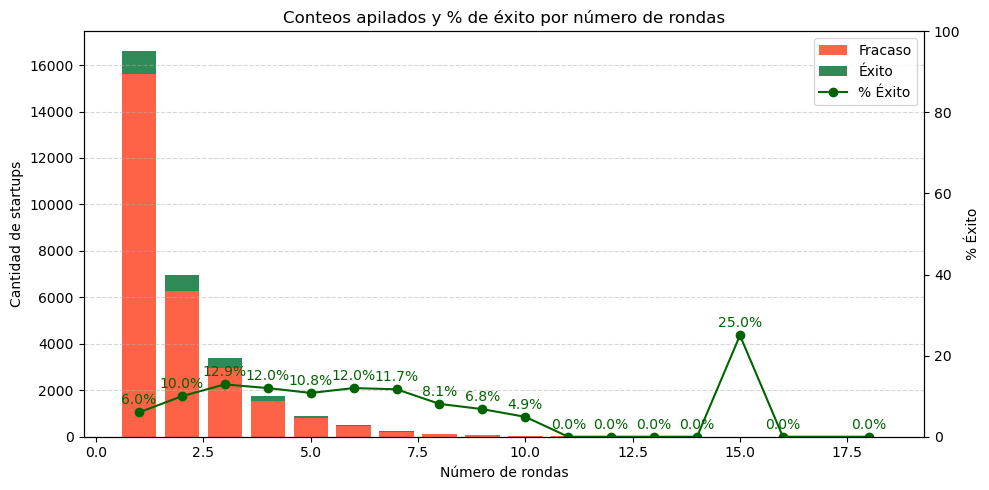

In [15]:
# 1) Agrupamos por número de rondas y exito
grp2 = (
    df.groupby('funding_rounds')['exito']
      .value_counts()
      .unstack(fill_value=0)
      .sort_index()
)
fails2 = grp2.get(0, pd.Series(dtype=int))
succs2 = grp2.get(1, pd.Series(dtype=int))
rnds   = fails2.index
tot2   = fails2 + succs2
pct2   = (succs2 / tot2 * 100).round(1)

# 2) Plot
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.bar(rnds, fails2,  color='tomato',    label='Fracaso')
ax1.bar(rnds, succs2, bottom=fails2, color='seagreen', label='Éxito')
ax1.set_xlabel("Número de rondas")
ax1.set_ylabel("Cantidad de startups")
ax1.set_title("Conteos apilados y % de éxito por número de rondas")
ax1.grid(axis='y', linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(rnds, pct2, color='darkgreen', marker='o', label='% Éxito')
ax2.set_ylabel("% Éxito")
ax2.set_ylim(0,100)

for x, p in zip(rnds, pct2):
    ax2.text(x, p+2, f"{p}%", ha='center', color='darkgreen')

h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper right')

plt.tight_layout()
plt.show()


### Combinación Sector–País (Top 5×Top 5)

Este gráfico muestra cómo se distribuyen las startups en los 5 sectores más frecuentes y los 5 países principales:

1. **Barras apiladas**  
   - Cada barra representa un sector.  
   - Los segmentos apilados (colores) corresponden al número de startups en cada país.  

2. **Línea de porcentaje de éxito**  
   - Línea negra con marcadores muestra el porcentaje medio de adquisiciones por sector, considerando todos los países.  

Este análisis permite ver, de un vistazo, en qué combinaciones sector–país se concentra el mayor volumen de startups y cuáles tienen la mayor tasa de éxito.  


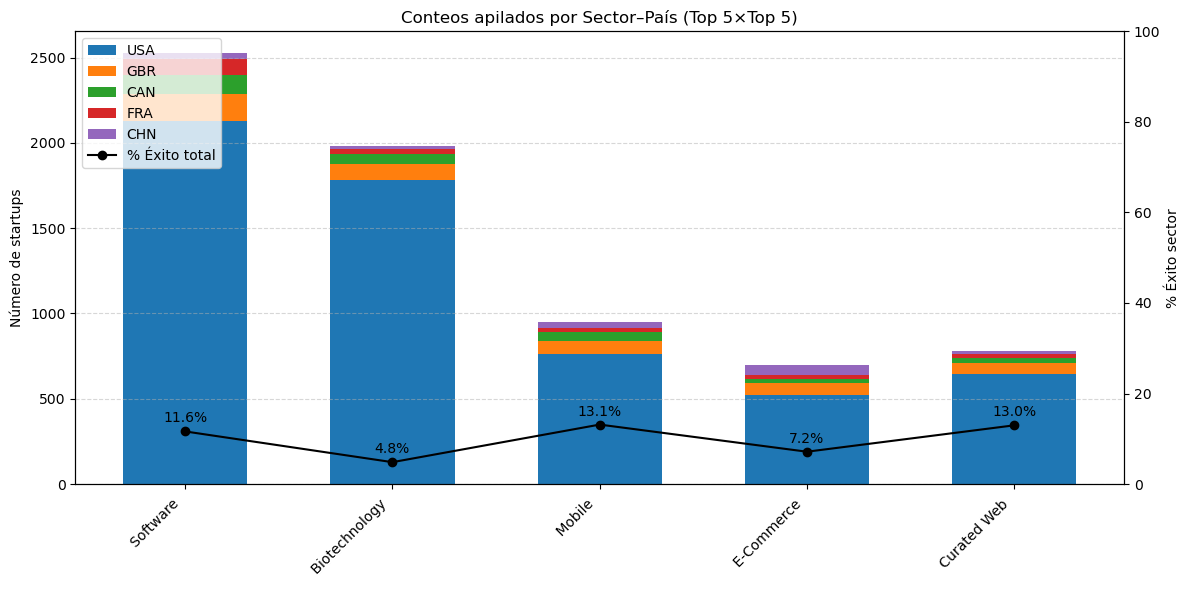

In [16]:
import numpy as np

# 1) Filtramos top 5 de cada uno
top_secures   = df['market'].value_counts().head(5).index
top_countries = df['country_code'].value_counts().head(5).index
sub = df[df['market'].isin(top_secures) & df['country_code'].isin(top_countries)]

# 2) Pivot counts y % éxito
pivot_cnt = sub.pivot_table(
    index='market', columns='country_code', values='exito',
    aggfunc=['count','mean']
)
cnts = pivot_cnt['count']
pcts = (pivot_cnt['mean'] * 100).round(1)

# 3) Para cada sector dibujamos barras apiladas por país y % línea
fig, ax1 = plt.subplots(figsize=(12,6))
width = 0.6
x = np.arange(len(top_secures))

# apilado
bottom = np.zeros(len(top_secures))
for c in top_countries:
    vals = cnts[c].reindex(top_secures).fillna(0)
    ax1.bar(x, vals, width, bottom=bottom, label=c)
    bottom += vals

ax1.set_xticks(x)
ax1.set_xticklabels(top_secures, rotation=45, ha='right')
ax1.set_ylabel("Número de startups")
ax1.set_title("Conteos apilados por Sector–País (Top 5×Top 5)")
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# línea de % éxito promedio por sector (sobre todos los países)
avg_pct = sub.groupby('market')['exito'].mean().reindex(top_secures) * 100
ax2 = ax1.twinx()
ax2.plot(x, avg_pct, color='black', marker='o', label='% Éxito total')
ax2.set_ylabel("% Éxito sector")
ax2.set_ylim(0,100)

for xi, p in zip(x, avg_pct):
    ax2.text(xi, p+2, f"{p:.1f}%", ha='center', color='black')

# leyenda combinada
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')

plt.tight_layout()
plt.show()


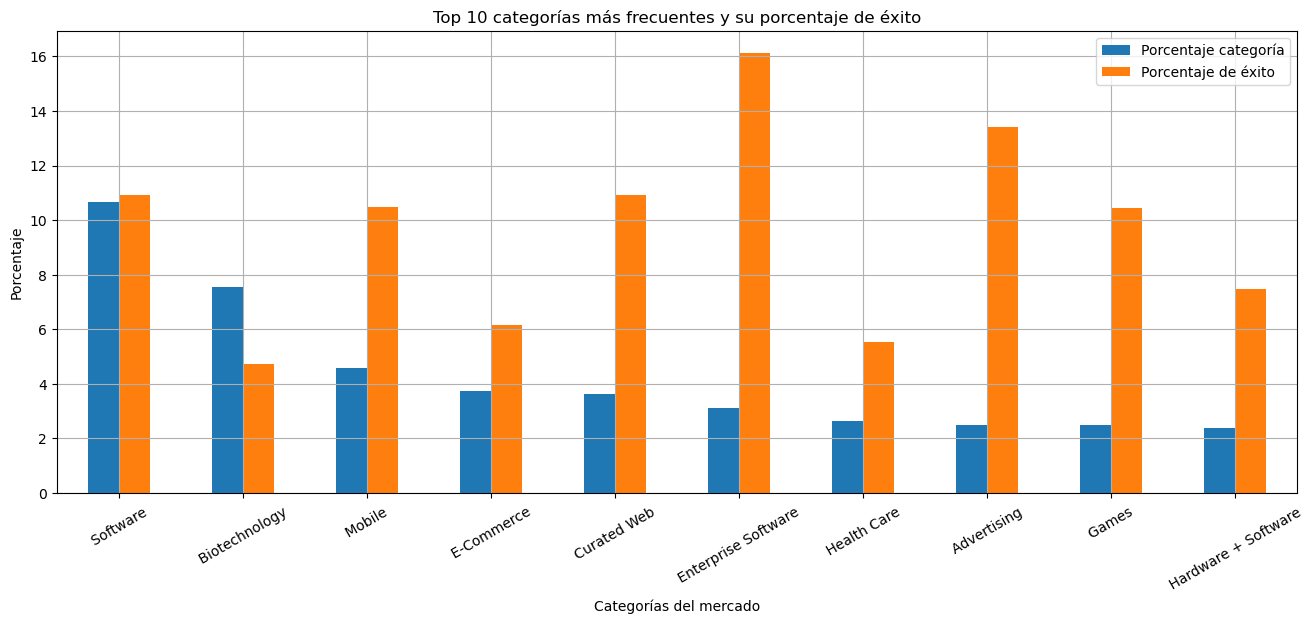

In [17]:
market_counts = df['market'].value_counts(normalize=True) * 100

# Calcular el porcentaje de 'exito = 1' para cada categoría en 'market'
success_percentage = df.groupby('market')['exito'].mean() * 100

# Crear un DataFrame con los porcentajes de las categorías y el porcentaje de éxito
result_df = pd.DataFrame({
    'Porcentaje categoría': market_counts,
    'Porcentaje de éxito': success_percentage
})

# Seleccionar las 10 categorías más frecuentes
top_categories = market_counts.head(10)

# Filtrar el DataFrame resultante para mostrar solo las categorías más frecuentes
result_df_top = result_df.loc[top_categories.index]

# Graficar
result_df_top.plot(kind='bar', figsize=(16, 6))

plt.title('Top 10 categorías más frecuentes y su porcentaje de éxito')
plt.xlabel('Categorías del mercado')
plt.ylabel('Porcentaje')
plt.xticks(rotation=30)
plt.grid()
plt.show()

Se puede observar que el número de startups **aumenta** cada año.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


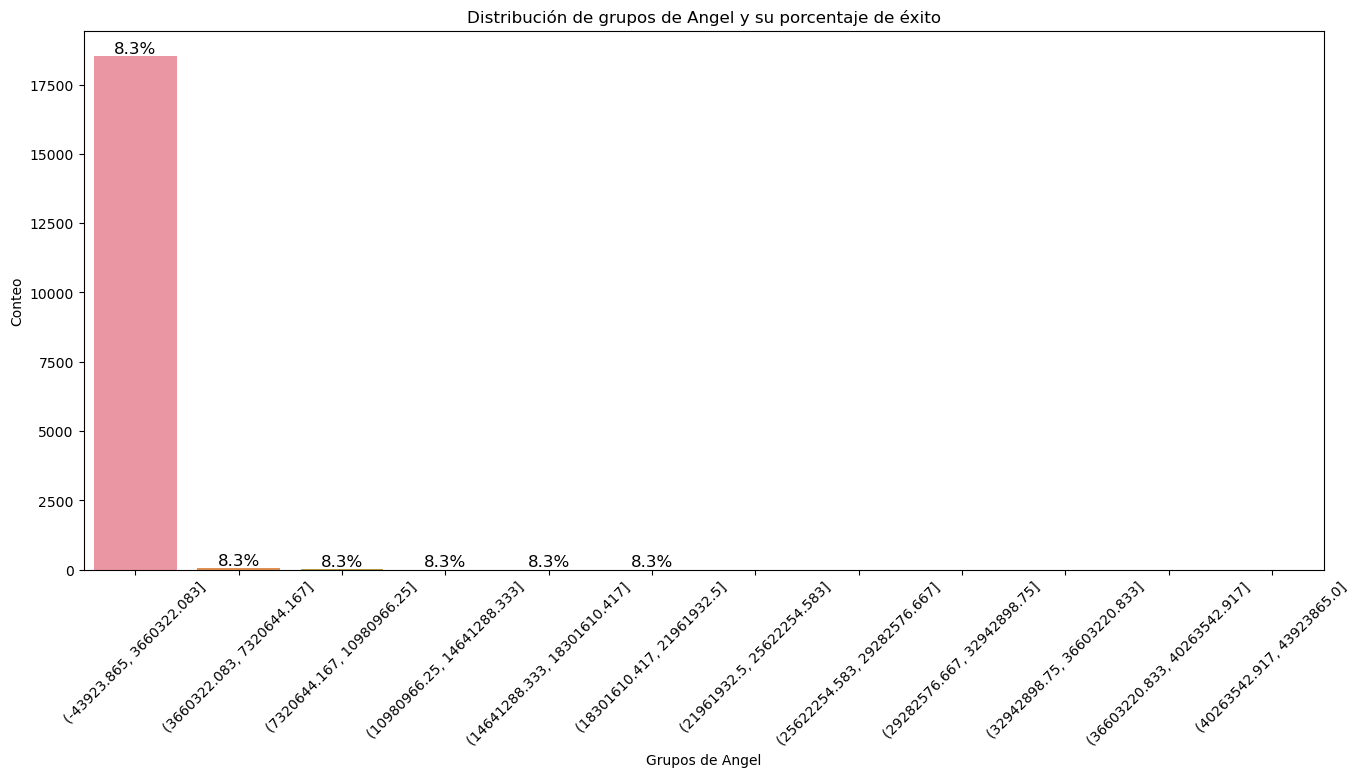

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dividir la variable 'angel' en 12 grupos utilizando pd.cut
df['angel_group'] = pd.cut(df['angel'], bins=12)

# Calcular el porcentaje de 'exito = 1' para cada grupo en 'angel_group'
success_percentage_angel_group = df.groupby('angel_group')['exito'].mean() * 100

# Graficar la distribución de 'angel_group'
plt.figure(figsize=(16, 7))

# Gráfico de barras con el conteo de cada grupo en 'angel_group'
sns.countplot(x='angel_group', data=df.dropna())

# Añadir los porcentajes de éxito encima de las barras
for p in plt.gca().patches:
    height = p.get_height()
    # Obtener el grupo de 'angel_group' correspondiente
    group_label = p.get_x() + p.get_width() / 2
    group_label = df['angel_group'].iloc[int(group_label)]  # Identificar la categoría por índice
    
    # Añadir el texto con el porcentaje de éxito en el gráfico
    plt.text(p.get_x() + p.get_width() / 2, height + 1, f'{success_percentage_angel_group[group_label]:.1f}%', 
             ha='center', va='bottom', fontsize=12)

plt.title('Distribución de grupos de Angel y su porcentaje de éxito')
plt.xlabel('Grupos de Angel')
plt.ylabel('Conteo')
plt.xticks(rotation=45)
plt.show()


Podemos observar que casi todas las startups son de `Software` y `Biotechnology`, seguidas de `Mobile`,`E-Commerce` y `Curated Webs`.

Realizamos un análisis de la variable a predecir en este caso, exito.

De momento vamos a asignar, la clase 1 a acquired y 0 a closed. Pero podríamos realizar otra distribución de clases si fuera de interés para el trabajo

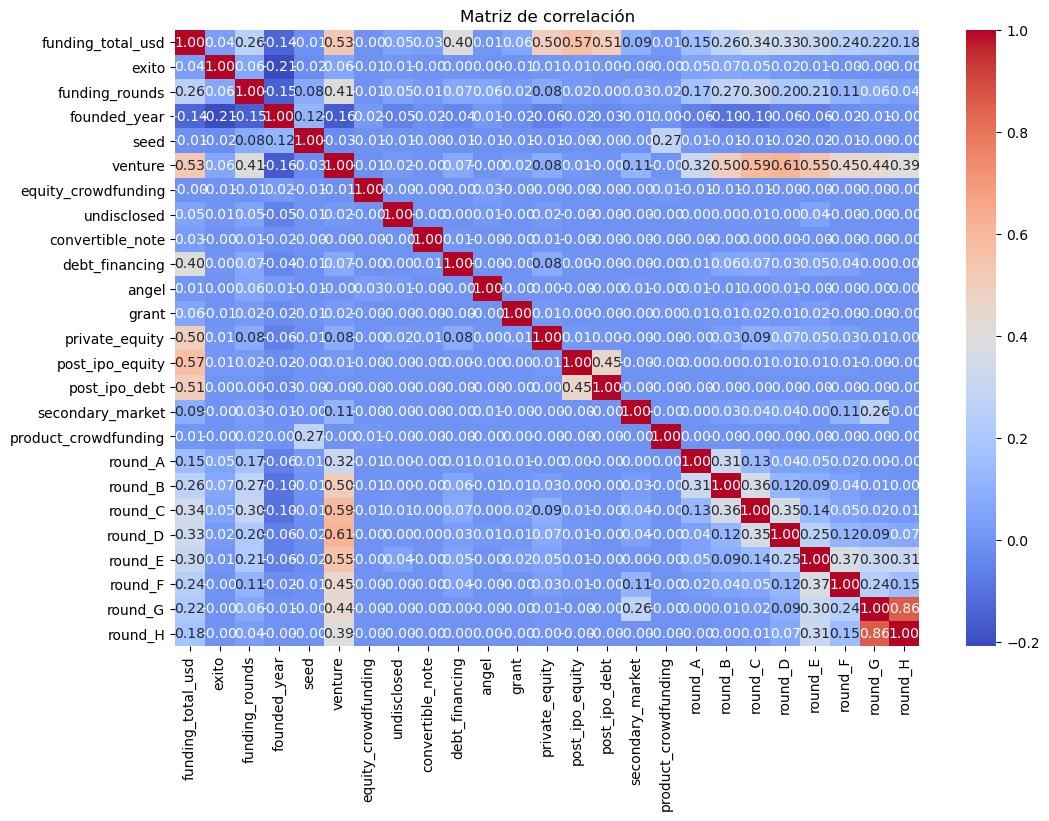

In [19]:
# Creamos una matriz de correlación entre las variables numéricas
numerical_df = df.select_dtypes(include=['number']) 
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.show()

Text(0.5, 1.0, 'Relación entre funding_rounds, founded_year y exito')

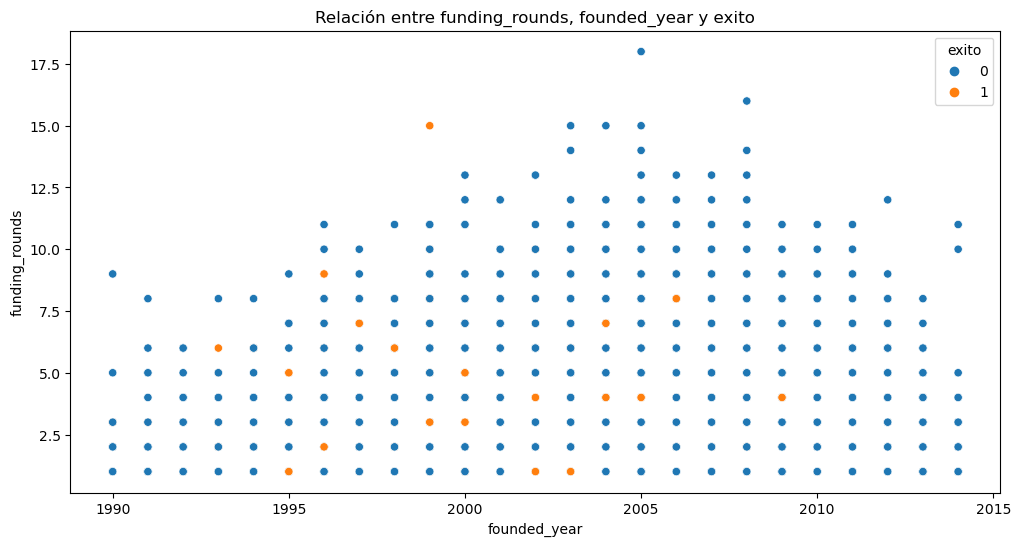

In [20]:
# Observamos que variables que están más correlacionadas con la variable de salida son funding_round y founded_year
# Observamos relacion entre funding_round, founded_year y variable objetivo 
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='founded_year', y='funding_rounds', hue='exito')
plt.title('Relación entre funding_rounds, founded_year y exito')

Más rondas de financiación aumentan la probabilidad de salida: Las startups con más rondas de financiación (4 o más) tienen mayor probabilidad de ser "adquiridas" o "cerradas" en comparación con aquellas con menos rondas (1-3), que suelen estar "operando". Esto sugiere que una financiación sostenida aumenta las posibilidades de un evento de salida.

<Figure size 1000x600 with 0 Axes>

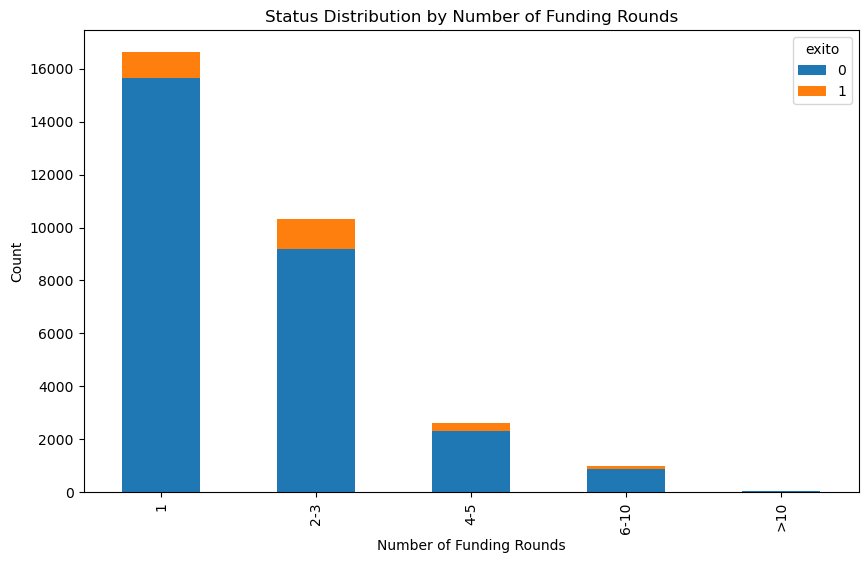

In [21]:
# Relationship 1: More Funding Rounds Increase Exit Likelihood
plt.figure(figsize=(10, 6))
df['funding_rounds_bin'] = pd.cut(df['funding_rounds'], bins=[0, 1, 3, 5, 10, float('inf')],
                                 labels=['1', '2-3', '4-5', '6-10', '>10'])
status_rounds = df.groupby(['funding_rounds_bin', 'exito']).size().unstack().fillna(0)
status_rounds.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Status Distribution by Number of Funding Rounds')
plt.xlabel('Number of Funding Rounds')
plt.ylabel('Count')
plt.legend(title='exito')
plt.show()


Mayores cantidades de financiación se correlacionan con adquisiciones: Las startups adquiridas tienen una mediana de financiación más alta (~$10M) en comparación con las cerradas y las que están operando (~$1M), lo que indica que más financiación aumenta la probabilidad de adquisición, mientras que menos financiación puede llevar al cierre.

<Figure size 1000x600 with 0 Axes>

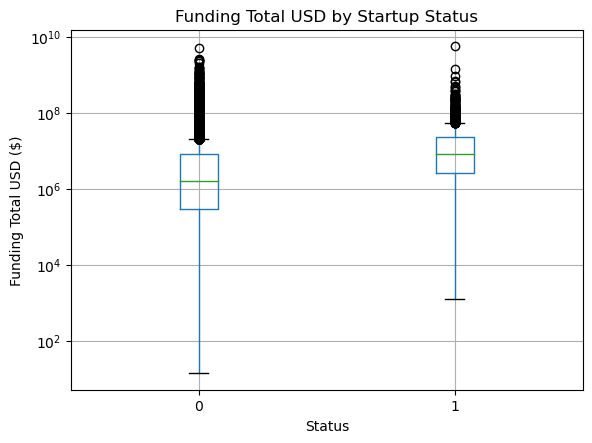

In [22]:
# Relationship 2: Higher Funding Amounts Correlate with Acquisitions
plt.figure(figsize=(10, 6))
df.boxplot(column='funding_total_usd', by='exito', showfliers=True)
plt.title('Funding Total USD by Startup Status')
plt.suptitle('')
plt.xlabel('Status')
plt.ylabel('Funding Total USD ($)')
plt.yscale('log')
plt.show()


La edad de la startup afecta su estado: Las startups más nuevas (post-2010) están mayormente "operando", mientras que las más antiguas (pre-2005) tienen más estados "adquiridas" y "cerradas". El período 2005-2010 muestra una mezcla equilibrada, sugiriendo que 5-15 años tras la fundación es un período crítico para salidas.


# Relationship 3: Startup Age Affects Status
plt.figure(figsize=(12, 6))
df['founded_year_bin'] = pd.cut(df['founded_year'], bins=range(1980, 2026, 5),
                               labels=[f'{i}-{i+4}' for i in range(1980, 2025, 5)])
status_year = df.groupby(['founded_year_bin', 'status']).size().unstack().fillna(0)
status_year.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Status Distribution by Founded Year')
plt.xlabel('Founded Year Range')
plt.ylabel('Count')
plt.legend(title='Status')
plt.show()


Tendencias de financiación a lo largo del tiempo: La financiación total alcanzó su pico alrededor de 2010-2015, reflejando un auge en la inversión en startups, mientras que el número promedio de rondas de financiación por startup se mantiene estable (1-2.5). Nota: Las tendencias antes de 1980 fueron excluidas debido a problemas de calidad de datos.

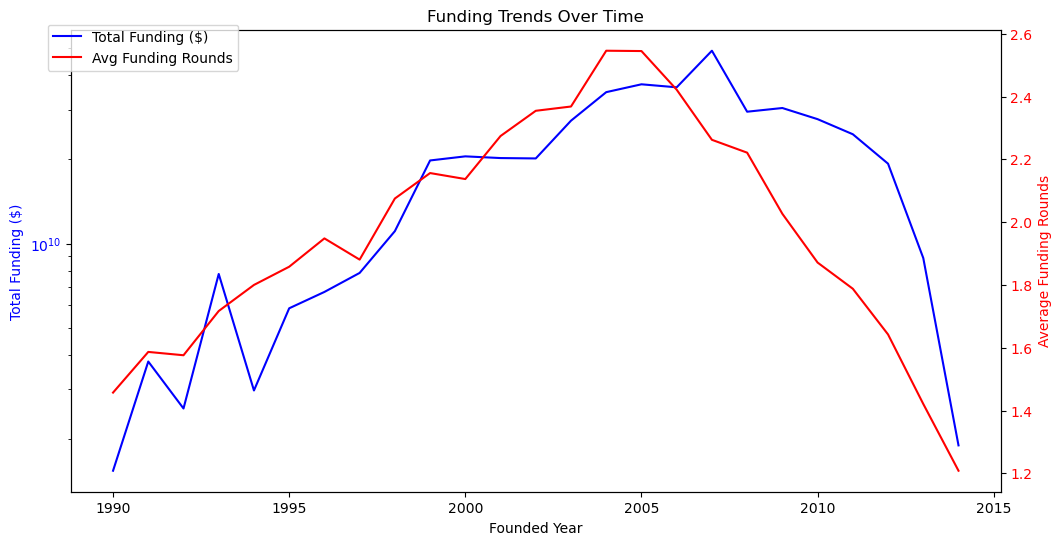

In [23]:

# Relationship 5: Funding Trends Over Time
df_yearly = df.groupby('founded_year').agg({
    'funding_total_usd': 'sum',
    'funding_rounds': 'mean'
}).reset_index()
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df_yearly['founded_year'], df_yearly['funding_total_usd'], 'b-', label='Total Funding ($)')
ax1.set_xlabel('Founded Year')
ax1.set_ylabel('Total Funding ($)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_yscale('log')
ax2 = ax1.twinx()
ax2.plot(df_yearly['founded_year'], df_yearly['funding_rounds'], 'r-', label='Avg Funding Rounds')
ax2.set_ylabel('Average Funding Rounds', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.title('Funding Trends Over Time')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()


## 4. Preparación de los datos para clasificación simple
Para poder realizar predicciones al principio, tenemos que lidiar con valores nulos primero realizaremos un analisis sencillo y los ignoraremos o sustituiremos, posteriormente usaremos tecnicas de imputacion y similares para intentar no perder informacion relevante.

Posteriormente aplicaremos una pipeline sencilla con knn para una primera clasificacion simple del problema

In [24]:
# Creamos pipeline para eliminar valores nulos y transformar variables categóricas con knn, evaluamos modelo con la funcion evaluar_modelo
#hacer train_test_split -> 30% para test 
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier as knn_neighbors

#hacer ahora train_test_split

# Separar columnas numéricas y categóricas, excluyendo la columna objetivo 'exito'
numerical_cols = df.select_dtypes(include=['float64', 'int64']).drop(columns=['exito']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
# Crear transformadores para columnas numéricas y categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=5, weights='uniform'))
        ]), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Crear pipeline completa
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', knn_neighbors())
])

# Convertir X y y manteniendo X como DataFrame para compatibilidad con ColumnTransformer
X = df.drop(columns=['exito'])
y = df['exito'].astype(float)  # Asegurarse de que y sea numérico

# Evaluar el pipeline
evaluar_pipeline(X, y.to_numpy(), pipeline, beta=1)

KeyError: "['exito'] not found in axis"

## 5. Deteccion de outliers



In [ ]:
# Configurar Matplotlib para mostrar gráficos inline en el notebook
%matplotlib inline

# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración para gráficos (estilo profesional)
sns.set_style('darkgrid')
sns.set_context("notebook", font_scale=0.8)

# Cargar el dataset
df = pd.read_csv('data/investments_VC.csv')

# Lista de columnas numéricas
num_cols = [
    'funding_total_usd', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
    'convertible_note', 'debt_financing', 'angel', 'grant', 'private_equity',
    'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding',
    'funding_rounds', 'founded_year'
]

# Preprocesamiento: Convertir columnas numéricas a float, eliminando comas
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')

# Crear una copia de los datos originales para comparación
df_original = df.copy()

# Lista para almacenar las columnas con outliers
cols_with_outliers = []

# Detección de outliers para todas las columnas
for col in num_cols:
    if col in df.columns:
        # Filtrar valores no nulos (y no ceros para columnas de financiación)
        if col in ['funding_total_usd', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
                   'convertible_note', 'debt_financing', 'angel', 'grant', 'private_equity',
                   'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding']:
            data_to_analyze = df[col][(df[col].notna()) & (df[col] != 0)]
        else:
            data_to_analyze = df[col][df[col].notna()]
        
        if len(data_to_analyze) < 4:  # Necesitamos al menos 4 valores para calcular cuartiles
            print(f"Omitiendo {col} debido a datos insuficientes")
            continue
        
        # Calcular cuartiles e IQR sobre datos no nulos (y no ceros para financiación)
        Q1 = data_to_analyze.quantile(0.25, interpolation='midpoint')
        Q3 = data_to_analyze.quantile(0.75, interpolation='midpoint')
        
        if pd.isna(Q1) or pd.isna(Q3):
            print(f"Omitiendo {col} debido a datos insuficientes")
            continue
        
        IQR = Q3 - Q1
        lower_bound = Q1 - 3.0 * IQR
        upper_bound = Q3 + 3.0 * IQR
        
        # Identificar outliers, ignorando NaN y ceros (para columnas de financiación)
        valid_data = df[col].notna()
        if col in ['funding_total_usd', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
                   'convertible_note', 'debt_financing', 'angel', 'grant', 'private_equity',
                   'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding']:
            valid_data = valid_data & (df[col] != 0)
        
        outliers = df[valid_data & ((df[col] < lower_bound) | (df[col] > upper_bound))]
        
        if not outliers.empty:
            print(f"Outliers detectados en {col} ({len(outliers)} valores)")
            cols_with_outliers.append((col, lower_bound, upper_bound))

# Procesar y graficar columnas con outliers en grupos de 4 por fila
for i in range(0, len(cols_with_outliers), 4):
    batch = cols_with_outliers[i:i+4]
    
    fig, axes = plt.subplots(1, len(batch), figsize=(3 * len(batch), 1.5))
    if len(batch) == 1:
        axes = [axes]
    
    for idx, (col, _, _) in enumerate(batch):
        sns.boxplot(x=df[col], fliersize=3, flierprops={"marker": "+"}, ax=axes[idx])
        axes[idx].set_title(f"{col} (con outliers)", fontsize=8)
        axes[idx].set_xlabel(col, fontsize=6)
        axes[idx].tick_params(axis='both', labelsize=6)
    
    plt.tight_layout()
    plt.show()
    
    for col, lower_bound, upper_bound in batch:
        original_values = df_original[col].copy()
        valid_data = df[col].notna()
        if col in ['funding_total_usd', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
                   'convertible_note', 'debt_financing', 'angel', 'grant', 'private_equity',
                   'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding']:
            valid_data = valid_data & (df[col] != 0)
        
        df.loc[valid_data, col] = np.clip(df.loc[valid_data, col], lower_bound, upper_bound)
        
        valid_mask = (~original_values.isna()) & (~df[col].isna())
        modified_count = (original_values[valid_mask] != df[col][valid_mask]).sum()
        print(f"\nValores modificados en {col}: {modified_count}")
        
        modified_mask = (original_values != df[col]) & valid_mask
        if modified_mask.any():
            first_modified_idx = modified_mask[modified_mask].index[0]
            original_value = original_values[first_modified_idx]
            new_value = df[col][first_modified_idx]
            mean_value = original_values[valid_mask].mean()
            
            print(f"Ejemplo del primer valor modificado en {col}:")
            print(f" - Índice: {first_modified_idx}")
            print(f" - Valor original: {original_value}")
            print(f" - Valor después del tratamiento: {new_value}")
            print(f" - Media del atributo: {mean_value:.2f}")
            print(f" - Diferencia del valor original respecto a la media: {abs(original_value - mean_value):.2f}")
    
    fig, axes = plt.subplots(1, len(batch), figsize=(3 * len(batch), 1.5))
    if len(batch) == 1:
        axes = [axes]
    
    for idx, (col, _, _) in enumerate(batch):
        sns.boxplot(x=df[col], fliersize=3, flierprops={"marker": "+"}, ax=axes[idx])
        axes[idx].set_title(f"{col} (post-tratamiento)", fontsize=8)
        axes[idx].set_xlabel(col, fontsize=6)
        axes[idx].tick_params(axis='both', labelsize=6)
    
    plt.tight_layout()
    plt.show()

# Guardar el dataset limpio
df.to_csv('data/no_outliers.csv', index=False)
print("Procesamiento completo. Los outliers han sido tratados y el dataset limpio ha sido guardado en 'data/no_outliers.csv'.")


## 6. Transformación del tipo de variable

En primer lugar, antes de estandarizar los datos, nos tenemos que asegurar de que están en su tipo correcto. Es por ello, por lo que primero hay que:
1. Transformar los tipos de datos que consideremos.
2. Imputar los valores perdidos

In [ ]:
# Para el punto número 8, realizamos una copia
# Vamos a crear nuevas variables transformadas a partir de las variables numéricas
df_transformed = df.copy()

In [ ]:
df.head()

Algunas de las transformaciones se han hecho anteriormente para poder representar las gráficas y analizar las variables. A continuación se explicarán las transformaciones de tipo realizadas:
1.  La variable **funding_total_usd** antes tenía sus valores separados por comas en forma de string, por lo que eliminamos las comas y lo parseamos a un valor entero.
    ```python
    df['funding_total_usd'] = (df['funding_total_usd'].astype(str).str.replace(',', '', regex=False))
    df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'], errors='coerce')
    
2.  La variable **founded_year** la podemos discretizar en rangos.
    ```python
    df['founded_year_group'] = pd.cut(
        df['founded_year'],
        bins=[1900,1925,1950,1975,2000,2015],
        labels=['1900–25','25–50','50–75','75–00','00–14']
    )

In [ ]:
df['founded_year_group'] = pd.cut(
    df['founded_year'],
    bins=[1900,1925,1950,1975,2000,2015],
    labels=['1900–25','25–50','50–75','75–00','00–14']
)

## 7. Imputación de valores perdidos

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# =====================
# Cargar datos
# =====================

input_path = "data/investments_VC.csv"
df = pd.read_csv(input_path, encoding="latin1")

# Limpiar funding_total_usd para convertirla a numérica
df['funding_total_usd'] = df['funding_total_usd'].str.replace(',', '').str.strip()
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'], errors='coerce')

# Identificar columnas
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# =====================
# Definir función para imputar con muestreo
# =====================

def impute_with_sampling(X):
    # Asegurarse de que X sea un DataFrame
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=numerical_cols)
    
    X = X.copy()  # Crear una copia para no modificar el original
    for col in X.columns:  # Iterar sobre cada columna
        column = X[col]
        # Extraer valores no nulos
        non_null_values = column[~column.isna()].values
        if len(non_null_values) == 0:  # Si no hay valores no nulos, usar 0 como fallback
            non_null_values = [0]
        # Contar valores nulos
        num_missing = column.isna().sum()
        if num_missing > 0:
            # Muestrear valores de los no nulos según su distribución
            sampled_values = np.random.choice(non_null_values, size=num_missing, replace=True)
            # Imputar los valores nulos
            X.loc[column.isna(), col] = sampled_values
    return X

# =====================
# Preprocesamiento
# =====================

# Pipeline para variables numéricas (imputar con muestreo)
numerical_pipeline = Pipeline(steps=[
    ('imputer', FunctionTransformer(impute_with_sampling, validate=False))
])

# Pipeline para variables categóricas
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))  # Imputar con la moda
])

# ColumnTransformer para aplicar imputaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ],
    remainder='passthrough'  # Mantener columnas no especificadas
)

# Aplicar preprocesamiento
df_preprocessed = preprocessor.fit_transform(df)

# Reconstruir nombres de columnas
new_columns = numerical_cols + categorical_cols

# Convertir a DataFrame
df_preprocessed = pd.DataFrame(df_preprocessed, columns=new_columns, index=df.index)

# Asegurarse de que las columnas numéricas sean float
for col in numerical_cols:
    df_preprocessed[col] = df_preprocessed[col].astype(float)

# Asegurarse de que las columnas categóricas sean string
for col in categorical_cols:
    df_preprocessed[col] = df_preprocessed[col].astype(str)

# Reordenar columnas para que coincidan con el formato deseado
desired_columns = [
    'permalink', 'name', 'homepage_url', 'category_list', 'market', 'funding_total_usd',
    'status', 'country_code', 'state_code', 'region', 'city', 'funding_rounds',
    'founded_at', 'founded_month', 'founded_quarter', 'founded_year',
    'first_funding_at', 'last_funding_at', 'seed', 'venture', 'equity_crowdfunding',
    'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
    'private_equity', 'post_ipo_equity', 'post_ipo_debt', 'secondary_market',
    'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D', 'round_E',
    'round_F', 'round_G', 'round_H'
]
# Asegurarse de que todas las columnas deseadas estén en df_final
df_final = df_preprocessed
for col in desired_columns:
    if col not in df_final.columns:
        df_final[col] = np.nan

# Seleccionar y reordenar columnas
df_final = df_final[desired_columns]

# =====================
# Guardar
# =====================

output_path = "data/investments_VC_imputed.csv"
df_final.to_csv(output_path, index=False)

print(f"✅ Dataset imputado guardado en {output_path}")

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# =====================
# Cargar datos
# =====================

# Cargar el dataset original
input_path = "data/investments_VC.csv"
df_original = pd.read_csv(input_path, encoding="latin1")

# Limpiar funding_total_usd para convertirla a numérica (como en la sección 1)
df_original['funding_total_usd'] = df_original['funding_total_usd'].str.replace(',', '').str.strip()
df_original['funding_total_usd'] = pd.to_numeric(df_original['funding_total_usd'], errors='coerce')

# Cargar el dataset imputado
imputed_path = "data/investments_VC_imputed.csv"
df_imputed = pd.read_csv(imputed_path)

# =====================
# Analizar valores faltantes
# =====================

print("=== Valores Faltantes en el Dataset Original ===")
missing_original = df_original.isna().sum()
for col, count in missing_original.items():
    print(f"{col}: {count}")

print("\n=== Valores Faltantes en el Dataset Imputado ===")
missing_imputed = df_imputed.isna().sum()
for col, count in missing_imputed.items():
    print(f"{col}: {count}")

# =====================
# Visualizar la distribución antes y después para varias columnas
# =====================

# Visualizar founded_year
plt.figure(figsize=(10, 6))
sns.kdeplot(df_original['founded_year'], label='Original', color='blue', fill=True)
sns.kdeplot(df_imputed['founded_year'], label='Imputed', color='orange', fill=True)
plt.title('Distribución de founded_year (Original vs Imputed)')
plt.xlabel('founded_year')
plt.ylabel('Densidad')
plt.legend()
plt.show()

# Visualizar funding_total_usd
plt.figure(figsize=(10, 6))
sns.kdeplot(df_original['funding_total_usd'], label='Original', color='blue', fill=True)
sns.kdeplot(df_imputed['funding_total_usd'], label='Imputed', color='orange', fill=True)
plt.title('Distribución de funding_total_usd (Original vs Imputed)')
plt.xlabel('funding_total_usd')
plt.ylabel('Densidad')
plt.legend()
plt.show()

# Opcional: Visualizar funding_rounds (puedes agregar más columnas si lo deseas)
plt.figure(figsize=(10, 6))
sns.kdeplot(df_original['funding_rounds'], label='Original', color='blue', fill=True)
sns.kdeplot(df_imputed['funding_rounds'], label='Imputed', color='orange', fill=True)
plt.title('Distribución de funding_rounds (Original vs Imputed)')
plt.xlabel('funding_rounds')
plt.ylabel('Densidad')
plt.legend()
plt.show()

## 8. Estandarización de los datos

Según la variable, aplicaremos un tipo de estandarización u otro.

Para que todas las variables numéricas estén en rangos comparables:

- **Z-score (StandardScaler)** en aquellas columnas con distribución relativamente “normal”  
  Calcula \((x - \mu)/\sigma\), de modo que la media quede en 0 y la desviación típica en 1.  
  Lo aplicamos a:
  - `funding_rounds`  
  - `founded_year`  

- **Min-Max (MinMaxScaler)** en las columnas con valores muy dispersos  
  Reescala los datos al rango \([0,1]\) según \((x - \min) / (\max - \min)\).  
  Lo aplicamos a:
  - `funding_total_usd`  
  - `seed`  
  - `angel`  
  - `venture`

Con esto, evitamos que las magnitudes de unas variables dominen a las otras cuando entren en el modelo.


In [ ]:
df[500:520]

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1) Columnas a estandarizar con Z-score
cols_std = ['funding_rounds', 'founded_year']

# 2) Columnas a escalar a [0,1]
cols_mm = ['funding_total_usd', 'seed', 'angel', 'venture']

# 3) Aplicar los escaladores y **actualizar** el DataFrame
df[cols_std] = StandardScaler().fit_transform(df[cols_std])
df[cols_mm]  = MinMaxScaler().fit_transform(df[cols_mm])

In [ ]:
df[500:520]

## 8. Creación de nuevas variables

Basándonos en el análisis exploratorio previo, vamos a crear nuevas variables que puedan ser relevantes para la predicción de adquisiciones de startups. Utilizaremos técnicas de transformación de variables numéricas, creación de variables a partir de fechas y generación de interacciones entre variables categóricas.

### 8.1 Transformación de variables numéricas

Primero vamos a analizar la distribución de nuestras variables numéricas principales (funding_total_usd y funding_rounds) y aplicar transformaciones para normalizar su distribución, siguiendo las técnicas de transformación logarítmica y raíz cuadrada.

In [ ]:
# Aplicamos transformación logarítmica a funding_total_usd para normalizar su distribución
# Primero convertimos la columna a numérico removiendo comas y espacios
df_transformed['log_funding_total_usd'] = np.log1p(
    pd.to_numeric(
        df_transformed['funding_total_usd']
            .astype(str)
            .str.replace(',', '', regex=False)
            .str.strip(),
        errors='coerce'
    )
)

# Aplicamos raíz cuadrada a funding_rounds
df_transformed['sqrt_funding_rounds'] = np.sqrt(df['funding_rounds'])

# Visualizamos las nuevas variables y comparamos con las originales
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histograma de la columna ' funding_total_usd ' (primero la convertimos a numérico)
sns.histplot(
	pd.to_numeric(df['funding_total_usd']
               	  .astype(str)
				  .str.replace(',', '')
				  .str.strip(),
				  errors='coerce')
	  .dropna(),
	bins=50,
	ax=axes[0, 0]
)
axes[0, 0].set_title('funding_total_usd original')

sns.histplot(df_transformed['log_funding_total_usd'].dropna(), bins=50, ax=axes[0, 1])
axes[0, 1].set_title('log_funding_total_usd')

sns.histplot(df['funding_rounds'].dropna(), bins=20, ax=axes[1, 0])
axes[1, 0].set_title('funding_rounds original')

sns.histplot(df_transformed['sqrt_funding_rounds'].dropna(), bins=20, ax=axes[1, 1])
axes[1, 1].set_title('sqrt_funding_rounds')

plt.tight_layout()
plt.show()

### 8.2 Creación de variables a partir de fechas

El dataset contiene varias variables con fechas importantes como `founded_at`, `first_funding_at`, y `last_funding_at`. Vamos a extraer información relevante de estas fechas para crear nuevas variables que puedan mejorar nuestro modelo.

In [ ]:
# Convertimos las columnas de fechas a formato datetime
date_columns = ['founded_at', 'first_funding_at', 'last_funding_at']

for col in date_columns:
    df_transformed[col] = pd.to_datetime(df_transformed[col], errors='coerce')

# Creamos nuevas variables a partir de las fechas
# 1. Extracción de año, mes y día de la fecha de fundación
df_transformed['founded_year_dt'] = df_transformed['founded_at'].dt.year
df_transformed['founded_month'] = df_transformed['founded_at'].dt.month
df_transformed['founded_quarter'] = df_transformed['founded_at'].dt.quarter

# 2. Tiempo desde fundación hasta primera financiación (en días)
df_transformed['days_to_first_funding'] = (df_transformed['first_funding_at'] - df_transformed['founded_at']).dt.days

# 3. Tiempo desde primera hasta última financiación (en días)
df_transformed['funding_duration_days'] = (df_transformed['last_funding_at'] - df_transformed['first_funding_at']).dt.days

# 4. Velocidad de financiación (rondas por año)
df_transformed['funding_velocity'] = df_transformed['funding_rounds'] / (df_transformed['funding_duration_days'] / 365 + 0.1)  # Evitamos división por cero

# Visualizamos las nuevas variables
plt.figure(figsize=(10, 6))
sns.histplot(df_transformed['days_to_first_funding'].dropna(), bins=50)
plt.title('Distribución de días desde fundación hasta primera financiación')
plt.xlabel('Días')
plt.show()

# Comparamos la velocidad de financiación entre startups adquiridas y no adquiridas
plt.figure(figsize=(10, 6))
sns.boxplot(x='exito', y='funding_velocity', data=df_transformed)
plt.title('Velocidad de financiación según adquisición')
plt.xlabel('Adquirida (1) vs No adquirida (0)')
plt.ylabel('Velocidad de financiación (rondas/año)')
plt.show()

## 9. Selección de variables

Ahora que hemos creado nuevas variables, vamos a utilizar técnicas de selección para identificar las más relevantes para nuestro modelo. Utilizaremos métodos basados en filtros, wrappers y análisis de correlaciones.

### 9.1 Análisis de correlaciones

Vamos a analizar las correlaciones entre nuestras variables numéricas para identificar posibles redundancias y seleccionar las más relevantes para el modelo.

In [ ]:
# Seleccionamos solo variables numéricas para el análisis de correlación, EXCLUYENDO la variable de salida 'exito'
numerical_vars = df_transformed.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'exito' in numerical_vars:
    numerical_vars.remove('exito')  # Nos aseguramos de remover la variable objetivo

print(f"Variables numéricas a analizar (sin la variable objetivo): {numerical_vars}")

# Calculamos la matriz de correlaciones
correlaciones = df_transformed[numerical_vars].corr().abs()

# Visualizamos la matriz de correlaciones
plt.figure(figsize=(16, 12))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de correlaciones entre variables numéricas (sin variable objetivo)')
plt.tight_layout()
plt.show()

# Implementamos la clase para selección de variables correlacionadas
from sklearn.base import TransformerMixin

class corr_selection(TransformerMixin):
    # Constructor de la clase
    def __init__(self, umbral=0.9, verbose=True):
        # Umbral deseado para determinar variables correlacionadas
        self.umbral = umbral
        # Parámetro que determina si imprimir información del proceso o no
        self.verbose = verbose
        
    # Método fit
    def fit(self, X, y=None):
        # Transformamos X en DataFrame por si acaso llega en formato ndarray
        X = pd.DataFrame(X)
        # Calculamos la matriz de correlaciones y la ponemos en valor absoluto
        correlaciones = X.corr().abs()
        # Seleccionamos el triángulo superior de la matriz de correlación
        upper = correlaciones.where(np.triu(np.ones(correlaciones.shape), k=1).astype('bool'))
        # Obtenemos los nombres de variables con correlación mayor al umbral deseado
        self.variables_a_eliminar = list(set([column for i, column in enumerate(upper.columns) if any(upper[column] > self.umbral)]))
        
        # Si queremos mostrar información se muestra el número de variables eliminadas y sus nombres
        if self.verbose:
            print('Se han eliminado {} variables por alta correlación, que son: {}'.format(len(self.variables_a_eliminar), self.variables_a_eliminar))
        # Devolvemos el objeto modificado
        return self
    
    # Método transform
    def transform(self, X):
        # Transformamos X en DataFrame por si acaso llega en formato ndarray
        X = pd.DataFrame(X)
        # Creamos una copia del DataFrame X para no perder los datos originales
        X_uncorr = X.copy()
        # Eliminamos las variables con alta correlación
        X_uncorr.drop(self.variables_a_eliminar, axis=1, inplace=True)
        # Devolvemos el DataFrame transformado
        return X_uncorr
    
    # Método para asignar valores de los híper-parámetros
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener valores de los híper-parámetros
    def get_params(self, deep=True):
        return {"umbral": self.umbral}

# Aplicamos la selección de variables correlacionadas a nuestro dataset
selector_corr = corr_selection(umbral=0.8)
X_numeric = df_transformed[numerical_vars].copy()
X_uncorr = selector_corr.fit_transform(X_numeric)

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X = df_transformed.drop(columns=['exito'])
y = df_transformed['exito']

# División inicial: 60% entrenamiento, 40% restante
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# División secundaria: 50% validación, 50% prueba del 40% restante
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Tamaños de los conjuntos: \nEntrenamiento: {X_train.shape}, Validación: {X_val.shape}, Prueba: {X_test.shape}")

In [ ]:
# Ajustar análisis de variables para usar solo X_train y y_train
numerical_vars = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calcular matriz de correlaciones en X_train
correlaciones = X_train[numerical_vars].corr().abs()

# Visualizar matriz de correlaciones
plt.figure(figsize=(16, 12))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de correlaciones entre variables numéricas (entrenamiento)')
plt.tight_layout()
plt.show()

# Aplicar selección de variables correlacionadas en X_train
selector_corr = corr_selection(umbral=0.8)
X_train_uncorr = selector_corr.fit_transform(X_train[numerical_vars])

# Actualizar X_val y X_test con las mismas variables seleccionadas
X_val_uncorr = X_val[X_train_uncorr.columns]
X_test_uncorr = X_test[X_train_uncorr.columns]

print(f"Variables seleccionadas tras eliminar correlaciones: {X_train_uncorr.columns.tolist()}")

### 9.2 Métodos basados en filtros

Aplicamos técnicas de selección de variables basadas en filtros para identificar las variables más relevantes para la predicción de adquisiciones. Utilizaremos los métodos SelectKBest con la puntuación f_classif para evaluar la importancia de cada variable.

In [ ]:
# Importamos las clases necesarias para la selección de variables basada en filtros
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectPercentile

# Preparamos los datos para la selección de variables
# Usamos solo las variables numéricas no correlacionadas para simplificar
X_select = df_transformed[X_uncorr.columns].dropna()
y_select = df_transformed.loc[X_select.index, 'exito']

# Aplicamos SelectKBest con f_classif para identificar las k mejores variables
k_best = 10  # Seleccionamos las 10 mejores variables
selector_f = SelectKBest(score_func=f_classif, k=k_best)
selector_f.fit(X_select, y_select)

# Obtenemos las puntuaciones y p-valores para cada variable
scores = pd.DataFrame({
    'Feature': X_select.columns,
    'F-Score': selector_f.scores_,
    'p-value': selector_f.pvalues_
})
scores = scores.sort_values('F-Score', ascending=False)

# Visualizamos las puntuaciones de las variables
plt.figure(figsize=(12, 6))
sns.barplot(x='F-Score', y='Feature', data=scores.head(k_best))
plt.title(f'Top {k_best} variables según F-Score')
plt.tight_layout()
plt.show()

# Seleccionamos las variables más importantes
selected_features_f = scores.head(k_best)['Feature'].tolist()
print(f"Variables seleccionadas con f_classif: {selected_features_f}")

# También aplicamos SelectKBest con mutual_info_classif para comparar resultados
selector_mi = SelectKBest(score_func=mutual_info_classif, k=k_best)
selector_mi.fit(X_select, y_select)

# Obtenemos las puntuaciones para cada variable
scores_mi = pd.DataFrame({
    'Feature': X_select.columns,
    'Mutual Info Score': selector_mi.scores_
})
scores_mi = scores_mi.sort_values('Mutual Info Score', ascending=False)

# Visualizamos las puntuaciones de información mutua
plt.figure(figsize=(12, 6))
sns.barplot(x='Mutual Info Score', y='Feature', data=scores_mi.head(k_best))
plt.title(f'Top {k_best} variables según Información Mutua')
plt.tight_layout()
plt.show()

# Comparamos las variables seleccionadas por ambos métodos
selected_features_mi = scores_mi.head(k_best)['Feature'].tolist()
print(f"Variables seleccionadas con mutual_info_classif: {selected_features_mi}")

# Variables comunes a ambos métodos
common_features = set(selected_features_f).intersection(set(selected_features_mi))
print(f"Variables comunes seleccionadas por ambos métodos: {common_features}")

### 9.3 Métodos basados en wrappers

Ahora aplicaremos métodos basados en wrappers para seleccionar variables, específicamente la técnica Recursive Feature Elimination (RFE) que elimina iterativamente las variables menos importantes.